<a href="https://colab.research.google.com/github/spaceBearAmadeus/OUTDATED-studentNeedsNavigator/blob/main/ROSE_Composer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth1 libqt5x11extras5 qsynth
Suggested packages:
  fluid-soundfont-gs timidity jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth1 libqt5x11extras5 qsynth
0 upgraded, 5 newly installed, 0 to remove and 20 not upgraded.
Need to get 120 MB of archives.
After this operation, 150 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libfluidsynth1 amd64 1.1.9-1 [137 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fluidsynth amd64 1.1.9-1 [20.7 kB]
Get:4 http://archi

In [ ]:
!pip install --upgrade pyfluidsynth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install pretty_midi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.6 MB 28.6 MB/s 
     |████████████████████████████████| 51 kB 6.2 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=c61b7a1b7a38a6bf14e5e99f4a417cc9cfb2b3e33346693f7679bccb4721fa45
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi


In [ ]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

AUDIO_DIR = pathlib.Path("data/maestro-v2.0.0")
ANNOTATIONS_FILE = "/content/data/maestro-v2.0.0.csv"

if not AUDIO_DIR.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

59252736/59243107 [==============================] - 1s 0us/step


In [ ]:
class Bach: 
  def __init__(self, annotations_file, audio_dir):  
    self.annotations = pd.read_csv(f"{annotations_file}")
    self.audio_dir = audio_dir 
    self._SAMPLING_RATE = 16000

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, midi_file_index):
    audio_sample_path = self._get_audio_sample_path(midi_file_index)
    label = self._get_audio_sample_label(midi_file_index)
    return audio_sample_path, label 

  def _get_audio_sample_path(self, midi_file_index):
    filenames = glob.glob(str(self.audio_dir/'**/*.mid*'))
    return filenames[midi_file_index]

  def _get_audio_sample_label(self, midi_file_index:int):
    return self.annotations.iloc[midi_file_index, 6]
  
  def get_pretty_midi(self, midi_file_index:int):
    '''retrieves pretty_midi object'''
    pm = pretty_midi.PrettyMIDI(self.__getitem__(midi_file_index)[0])
    return pm

  #DATA VISUALIZATION METHODS
  def display_audio(self, pm:pretty_midi.PrettyMIDI, seconds=30):
    '''generates a mini .wav player in the markdown cell'''
    waveform = pm.fluidsynth(fs=self._SAMPLING_RATE)
    # Take a sample of the generated waveform to mitigate kernel resets
    waveform_short = waveform[:seconds*self._SAMPLING_RATE]
    return display.Audio(waveform_short, rate=self._SAMPLING_RATE)

  def fetch_inspect_MIDI_instrument(self, pm:pretty_midi.PrettyMIDI, show:Optional[bool]=False):
    '''retrieves instrument(s) in song, right now just [0], and shows data if show==True'''
    instrument = pm.instruments[0] 
    instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
    if show:
      print("\n*-------------------------------------------*")
      print(f"{'            '} \033[1;36mINSTRUMENT INFORMATION\033[0m")
      print(f"*-------------------------------------------*")
      print(f"\033[0;34m{' '}NUMBER_OF_INSTRUMENTS:\033[0m {len(pm.instruments)}")
      print("*-------------------------------------------*")
      print(f"\033[0;34m{' '}INSTRUMENT_NAME:\033[0m {instrument_name}") 
      print("*-------------------------------------------*") 
      for i, note in enumerate(instrument.notes[:10]):
        note_name = pretty_midi.note_number_to_name(note.pitch)
        duration = note.end - note.start
        print(f"{' '}{i}: \033[0;31mPITCH\033[0m={note.pitch}, \033[0;32mNOTE_NAME\033[0m={note_name}, \033[0;33mDURATION\033[0m={duration:.4f}\n")
    print("*-------------------------------------------*") 
    print("\n")
    return instrument 

  def midi_to_notes_df(self, prettyMidi:Optional[pretty_midi.PrettyMIDI]=None, 
                       midi_file_index:Optional[int]=None) -> pd.DataFrame:
    '''if pm is given, default to the instantiated pm object, else custom index with same method!'''
    try:
      if midi_file_index:
        instrument = self.get_pretty_midi(midi_file_index).instruments[0]
      elif prettyMidi:
        instrument = prettyMidi.instruments[0]

      notes = collections.defaultdict(list)
      sorted_notes = sorted(instrument.notes, key=lambda note: note.start)#<-sort by start time
      prev_start = sorted_notes[0].start

      for note in sorted_notes:
        start = note.start 
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start
      
      return pd.DataFrame({name: np.array(value) for name, value in notes.items()})
    
    except: 
      if midi_file_index and prettyMidi:
        print("Cannot have pm AND midi_file_index!")
        return None 

  def get_note_names(self, df:pd.DataFrame) -> np.ndarray:
    '''remember that this produces a FUNC'''
    return np.vectorize(pretty_midi.note_number_to_name)

  def plot_piano_roll(self, notes:pd.DataFrame, count:Optional[int]=None):
    if count:
      title = f"First {count} notes"
    else:
      title = f"Entire track"
      count = len(notes['pitch'])
    
    plt.figure(figsize=(22,6))
    x = np.stack([notes['pitch'], notes['pitch']], axis=0)
    y = np.stack([notes['start'], notes['end']], axis=0)
    plt.plot(y[:, :count], 
             x[:, :count], 
             color="m", 
             marker=".",
             markersize=8,
             markerfacecolor="b",
             snap=True)
    plt.xlabel('Time (s)')
    plt.ylabel('Pitch')
    _ = plt.title(title)

  def plot_note_distributions(self, notes_df:pd.DataFrame, drop_percentile=2.5):
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 3, 1)
    sns.histplot(notes_df, x="pitch", bins=20, kde=True)

    plt.subplot(1, 3, 2)
    max_step = np.percentile(notes_df['step'], 100 - drop_percentile)
    sns.histplot(notes_df, x="step", bins=np.linspace(0, max_step, 21))

    plt.subplot(1, 3, 3)
    max_duration = np.percentile(notes_df['duration'], 100 - drop_percentile)
    sns.histplot(notes_df, x="duration", bins=np.linspace(0, max_step, 21))
   


rose = Bach(ANNOTATIONS_FILE, AUDIO_DIR)

In [ ]:
pm = rose.get_pretty_midi(666) #<-index number of the sample we are inspecting

In [ ]:
rose.display_audio(pm)

In [ ]:
midi_1 = rose.fetch_inspect_MIDI_instrument(pm, show=True)


*-------------------------------------------*
             INSTRUMENT INFORMATION
*-------------------------------------------*
 NUMBER_OF_INSTRUMENTS: 1
*-------------------------------------------*
 INSTRUMENT_NAME: Acoustic Grand Piano
*-------------------------------------------*
 0: PITCH=68, NOTE_NAME=G#4, DURATION=0.3990

 1: PITCH=65, NOTE_NAME=F4, DURATION=1.1250

 2: PITCH=77, NOTE_NAME=F5, DURATION=0.2240

 3: PITCH=72, NOTE_NAME=C5, DURATION=0.7469

 4: PITCH=56, NOTE_NAME=G#3, DURATION=1.5750

 5: PITCH=77, NOTE_NAME=F5, DURATION=0.4094

 6: PITCH=67, NOTE_NAME=G4, DURATION=1.0990

 7: PITCH=76, NOTE_NAME=E5, DURATION=0.4469

 8: PITCH=79, NOTE_NAME=G5, DURATION=0.3781

 9: PITCH=58, NOTE_NAME=A#3, DURATION=1.4594

*-------------------------------------------*




In [ ]:
#these perform the same function but using different params to specify different files:
pm_df = rose.midi_to_notes_df(prettyMidi=pm)

custom_i_df = rose.midi_to_notes_df(midi_file_index=6)

In [ ]:
#note_name_array = rose.get_note_names(pm_df['pitch'])
pm_df

,pitch,start,end,step,duration
0,56,1.072917,2.647917,0.000000,1.575000
1,65,1.075000,2.200000,0.002083,1.125000
2,53,1.097917,9.455208,0.022917,8.357292
3,68,1.501042,1.900000,0.403125,0.398958
4,72,1.859375,2.606250,0.358333,0.746875
...,...,...,...,...,...
1861,64,350.508333,351.203125,0.576042,0.694792
1862,41,351.618750,355.058333,1.110417,3.439583
1863,57,351.703125,354.889583,0.084375,3.186458
1864,60,351.796875,354.813542,0.093750,3.016667


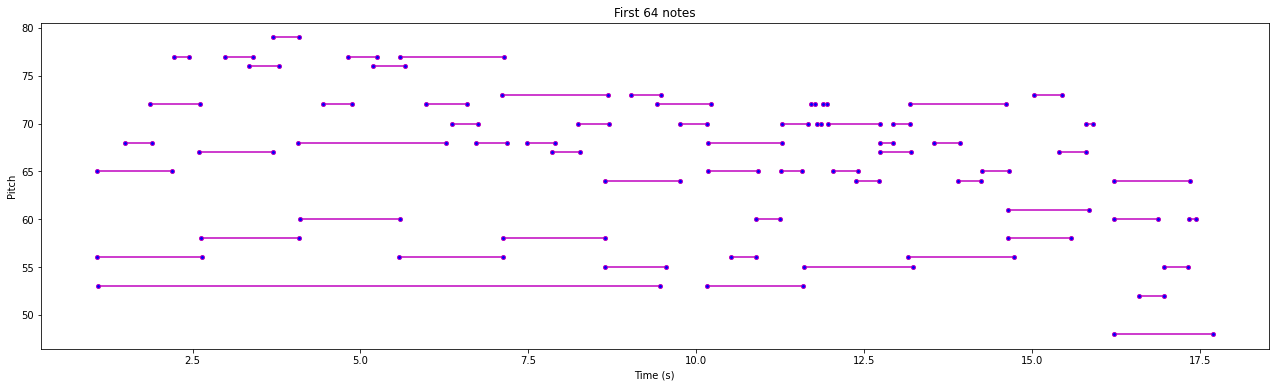

In [ ]:
rose.plot_piano_roll(pm_df, count=64)

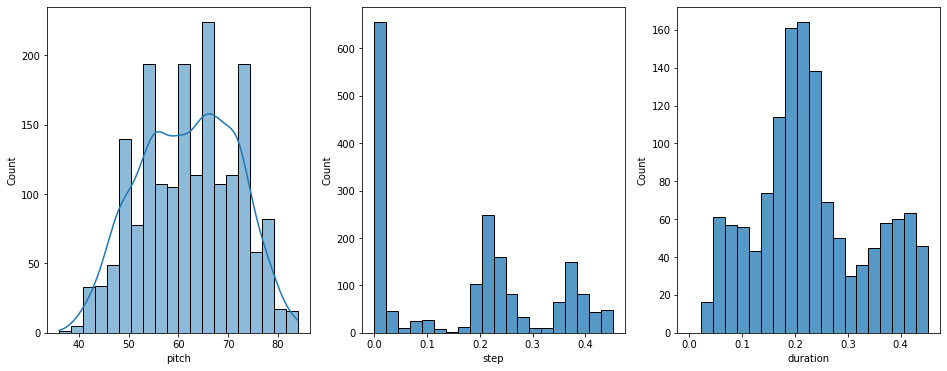

In [ ]:
rose.plot_note_distributions(pm_df)